<a href="https://colab.research.google.com/github/JunhOpportunity/AI_lab/blob/main/week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-617513143.py:17: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SPEECH_FILE = download_asset("/content/mynameisjunho.mov")


Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
HELLO|MY|NAME|IS|JUNO|


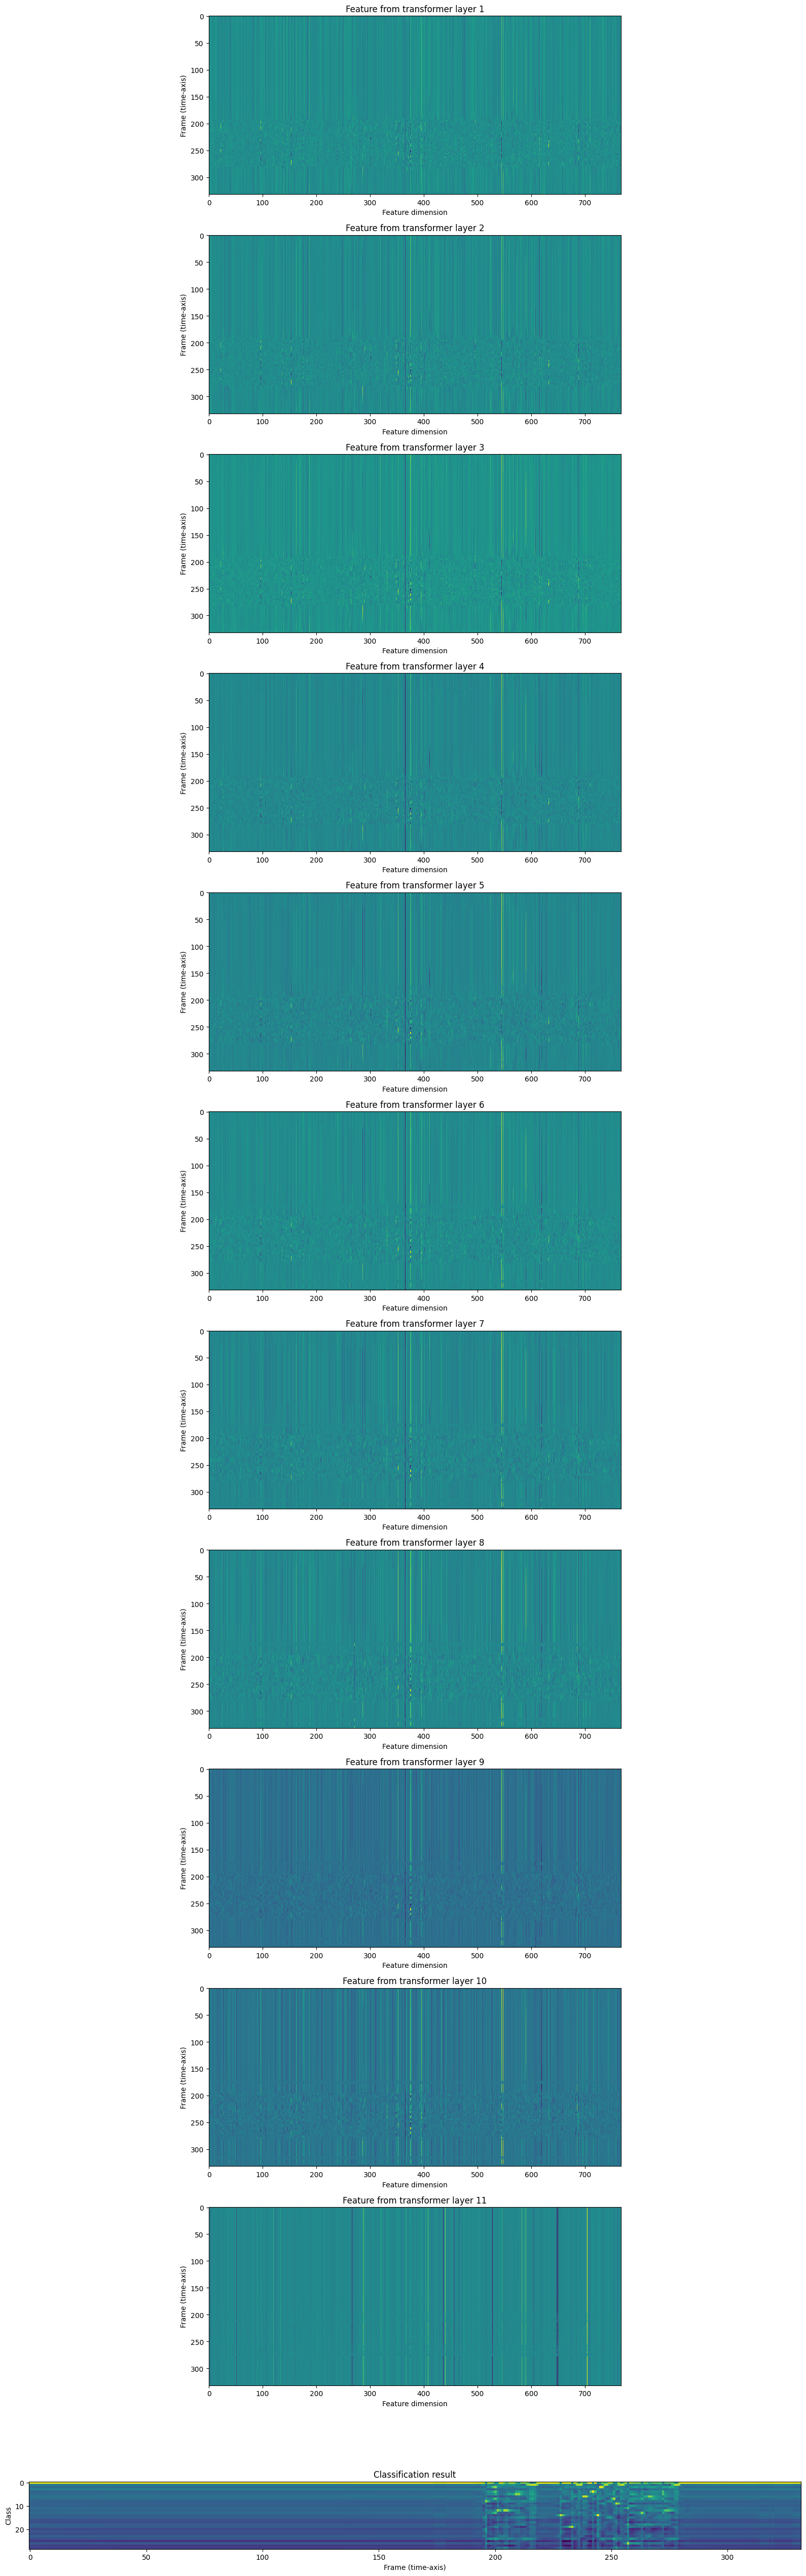

In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
# !pip install librosa

# Speech Recognition with wave2fec2 실습
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("/content/mynameisjunho.mov")



bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

# print("Sample Rate:", bundle.sample_rate)

# print("Labels:", bundle.get_labels())

model = bundle.get_model().to(device)

# print(model.__class__)

IPython.display.Audio(SPEECH_FILE)

waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

with torch.inference_mode():
    features, _ = model.extract_features(waveform)

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

with torch.inference_mode():
    emission, _ = model(waveform)

plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print(transcript)
IPython.display.Audio(SPEECH_FILE)


# # Audio Feature Extractions 실습

# from IPython.display import Audio
# from matplotlib.patches import Rectangle
# from torchaudio.utils import download_asset


# torch.random.manual_seed(0)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


# def plot_waveform(waveform, sr, title="Waveform", ax=None):
#     waveform = waveform.numpy()

#     num_channels, num_frames = waveform.shape
#     time_axis = torch.arange(0, num_frames) / sr

#     if ax is None:
#         _, ax = plt.subplots(num_channels, 1)
#     ax.plot(time_axis, waveform[0], linewidth=1)
#     ax.grid(True)
#     ax.set_xlim([0, time_axis[-1]])
#     ax.set_title(title)


# def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
#     if ax is None:
#         _, ax = plt.subplots(1, 1)
#     if title is not None:
#         ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     im = ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


#     #Add colorbar
#     char = plt.colorbar(im,ax=ax)
#     char.set_label('Power (dB)', rotation=270, labelpad=15)


# def plot_fbank(fbank, title=None):
#     fig, axs = plt.subplots(1, 1)
#     axs.set_title(title or "Filter bank")
#     axs.imshow(fbank, aspect="auto")
#     axs.set_ylabel("frequency bin")
#     axs.set_xlabel("mel bin")

# # Load audio
# SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# # Define transform
# spectrogram = T.Spectrogram(n_fft=512)

# # Perform transform
# spec = spectrogram(SPEECH_WAVEFORM)

# fig, axs = plt.subplots(2, 1)
# plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
# plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
# fig.tight_layout()

# n_ffts = [32, 128, 512, 2048]
# hop_length = 64

# specs = []
# for n_fft in n_ffts:
#     spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
#     spec = spectrogram(SPEECH_WAVEFORM)
#     specs.append(spec)

# fig, axs = plt.subplots(len(specs), 1, sharex=True)
# for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
#     plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
#     axs[i].set_xlabel(None)
# fig.tight_layout()

# # Downsample to half of the original sample rate
# speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# # Upsample to the original sample rate
# speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

# # Apply the same spectrogram
# spectrogram = T.Spectrogram(n_fft=512)

# spec0 = spectrogram(SPEECH_WAVEFORM)
# spec2 = spectrogram(speech2)
# spec3 = spectrogram(speech3)

# # Visualize it
# fig, axs = plt.subplots(3, 1)
# plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
# axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
# plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
# plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
# fig.tight_layout()

# # GriffinLim
# # Define transforms
# n_fft = 1024
# spectrogram = T.Spectrogram(n_fft=n_fft)
# griffin_lim = T.GriffinLim(n_fft=n_fft)

# # Apply the transforms
# spec = spectrogram(SPEECH_WAVEFORM)
# reconstructed_waveform = griffin_lim(spec)

# _, axes = plt.subplots(2, 1, sharex=True, sharey=True)
# plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
# plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
# Audio(reconstructed_waveform, rate=SAMPLE_RATE)


# # Mel Filter Bank
# n_fft = 256
# n_mels = 64
# sample_rate = 6000

# mel_filters = F.melscale_fbanks(
#     int(n_fft // 2 + 1),
#     n_mels=n_mels,
#     f_min=0.0,
#     f_max=sample_rate / 2.0,
#     sample_rate=sample_rate,
#     norm="slaney",
# )

# plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

# # MelSpectrogram
# n_fft = 1024
# win_length = None
# hop_length = 512
# n_mels = 128

# mel_spectrogram = T.MelSpectrogram(
#     sample_rate=sample_rate,
#     n_fft=n_fft,
#     win_length=win_length,
#     hop_length=hop_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     norm="slaney",
#     n_mels=n_mels,
#     mel_scale="htk",
# )

# melspec = mel_spectrogram(SPEECH_WAVEFORM)

# plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# melspec_librosa = librosa.feature.melspectrogram(
#     y=SPEECH_WAVEFORM.numpy()[0],
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     win_length=win_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     n_mels=n_mels,
#     norm="slaney",
#     htk=True,
# )

# plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

# mse = torch.square(melspec - melspec_librosa).mean().item()
# print("Mean Square Difference: ", mse)

# # MFCC
# n_fft = 2048
# win_length = None
# hop_length = 512
# n_mels = 256
# n_mfcc = 256

# mfcc_transform = T.MFCC(
#     sample_rate=sample_rate,
#     n_mfcc=n_mfcc,
#     melkwargs={
#         "n_fft": n_fft,
#         "n_mels": n_mels,
#         "hop_length": hop_length,
#         "mel_scale": "htk",
#     },
# )

# mfcc = mfcc_transform(SPEECH_WAVEFORM)

# plot_spectrogram(mfcc[0], title="MFCC")

# # LFCC
# n_fft = 2048
# win_length = None
# hop_length = 512
# n_lfcc = 256

# lfcc_transform = T.LFCC(
#     sample_rate=sample_rate,
#     n_lfcc=n_lfcc,
#     speckwargs={
#         "n_fft": n_fft,
#         "win_length": win_length,
#         "hop_length": hop_length,
#     },
# )

# lfcc = lfcc_transform(SPEECH_WAVEFORM)
# plot_spectrogram(lfcc[0], title="LFCC")

# # Pitch
# pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

# def plot_pitch(waveform, sr, pitch):
#     figure, axis = plt.subplots(1, 1)
#     axis.set_title("Pitch Feature")
#     axis.grid(True)

#     end_time = waveform.shape[1] / sr
#     time_axis = torch.linspace(0, end_time, waveform.shape[1])
#     axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

#     axis2 = axis.twinx()
#     time_axis = torch.linspace(0, end_time, pitch.shape[1])
#     axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

#     axis2.legend(loc=0)


# plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)
